# Import Libraries

In [79]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.utils import load_img,array_to_img, img_to_array
from PIL import Image
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L1, L2, L1L2
from keras.models import Model, Sequential, load_model
from keras.layers import Dropout, BatchNormalization 
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten,GlobalAveragePooling2D, Reshape, Input, Average
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.applications import DenseNet121, DenseNet201, ResNet152, VGG19
from sklearn.metrics import classification_report,confusion_matrix

In [80]:
path = 'C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/Multi-class Weather Dataset'

# Exploratory DA

In [81]:
# We have 11 different weather conditions
os.listdir(path)

['Cloudy', 'Rain', 'Shine', 'Sunrise']

## Data preview

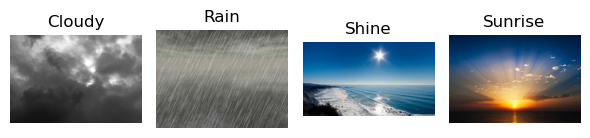

In [82]:
fig = plt.figure(figsize=(6,6)) 
rows = 3
columns = 4


for i, image_filename in enumerate(os.listdir(path)):

    first_img_path = os.listdir(os.path.join(path, image_filename))[0]
    first_image = imread(os.path.join(path, image_filename, first_img_path))
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(first_image)
    plt.title('{}'.format(image_filename, fontsize=10))

plt.tight_layout()
plt.show()

**Let's find out the average dimensions of these images.**

In [83]:
dim1 = []    # width
dim2 = []    # height
colors = []  # color channel

for i, image_filename in enumerate(os.listdir(path)):
    
    subfolders_path = os.path.join(path, image_filename)
    print(subfolders_path)
    
    for image_path in os.listdir(subfolders_path):
        
        image = imread(os.path.join(subfolders_path,image_path))

        # handling gray scale images if any
        if len(image.shape) < 3:
            image = image.reshape(image.shape+(1,))
            
        d1,d2,color = image.shape
        dim1.append(d1)
        dim2.append(d2)
        colors.append(color)

C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/Multi-class Weather Dataset\Cloudy
C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/Multi-class Weather Dataset\Rain
C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/Multi-class Weather Dataset\Shine
C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/Multi-class Weather Dataset\Sunrise


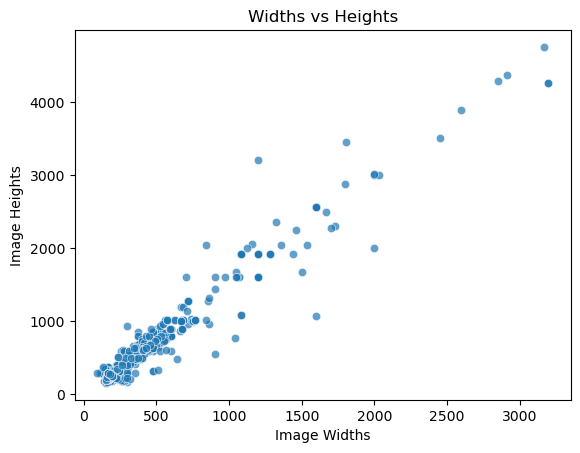

In [84]:
# There is a wide variety of image dimensions in the dataset
sns.scatterplot(x=dim1, y=dim2, alpha = 0.7)
plt.xlabel('Image Widths')
plt.ylabel('Image Heights')
plt.title('Widths vs Heights');


- The image widths reach up to 3000.
- The image heights reach up to 5000.

In [85]:
# mean of images width
np.mean(dim1)

334.75377777777777

In [86]:
# mean of images height
np.mean(dim2)

506.3031111111111

In [87]:
# number of color channels found
np.unique(colors)

array([1, 3, 4])

The number of color channels found in the images are 1, 3 and 4 :

- "1" : Indicates grayscale images, which have a single color channel.
- "3" : Represents RGB (Red, Green, Blue) images, where each pixel is represented by three color channels.
- "4" : Indicates RGBA (Red, Green, Blue, Alpha) images, which include an additional alpha channel for transparency or opacity information.


 - It's beneficial for the input images to have the same size when training a CNN. Therefore we could specify the input_shape to be (373,520,3).

In [88]:
# mean of all images dimensions
input_shape =  (224,224,3)

In [89]:
all_data_sum=0
images_count_dict = {}
for image_filename in os.listdir(path):

    folder_path = os.path.join(path, image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    all_data_sum+= images_count
    print('{} folder has {} images'.format(image_filename ,  images_count))

print("\nTotal Number of Images: {} image".format(all_data_sum))


Cloudy folder has 300 images
Rain folder has 215 images
Shine folder has 253 images
Sunrise folder has 357 images

Total Number of Images: 1125 image


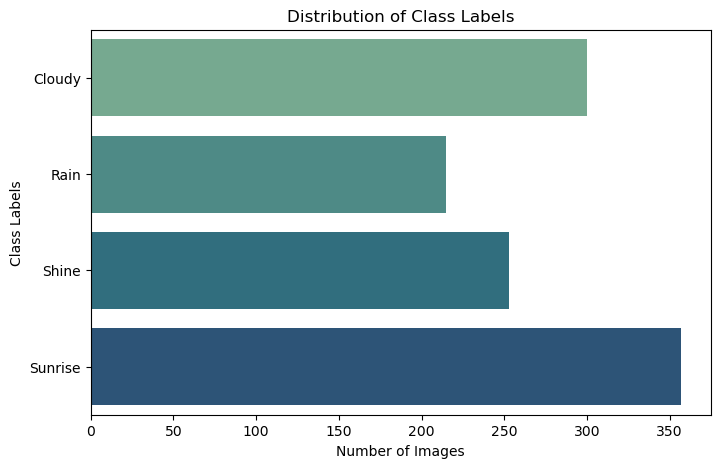

In [90]:
data = list(images_count_dict.items())

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(y=[x[0] for x in data], x=[x[1] for x in data], palette='crest',orient='horizontal')
plt.ylabel('Class Labels')
plt.xlabel('Number of Images')
plt.title('Distribution of Class Labels');

_______________________________

# Data Preprocessing

 ## Problem
- **Since we have an imbalanced dataset and relatively small dataset, we need to consider taking some steps, such as:**
    - Collecting more data
    - Data Augmentation
    - Choosing appropriate evaluation metrics that are robust to class imbalances. 

## Solution
- **Data collection**: 
     - We have collected more data from another datasets, such as, [multi-class-weather-dataset](https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset/data).

- **Data Preprocessing**:
   - We've utilized data augmentation techniques to increase the number of data and balance it. By applying various transformations to the existing data, such as rotation, shifting, flipping, and zooming, data augmentation helped create additional training examples.
   
### ImageDataGenerator Used Parameters:

- `rotation_range`: Random rotation applied to the images within 20 degrees.
- `width_shift_range`: Random horizontal shift applied to the images as a fraction of total width (10%).
- `height_shift_range`: Random vertical shift applied to the images as a fraction of total height (10%).
- `brightness_range`: Range for randomly adjusting brightness of the images from the range [0.5-1.5].
- `shear_range`: Random shear intensity applied to the images (15%).
- `zoom_range`: Range for randomly zooming into the images (20%).
- `horizontal_flip`: Randomly flips images horizontally.
- `fill_mode`: Strategy for filling in newly created pixels.
- `rescale`: Rescaling factor for pixel values normalization.

These parameters are applied to augment the training data and enhance the robustness and generalization of the model.


In [91]:
# paths to new dataset
train_path = 'C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/train'
test_path = 'C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/test'

In [92]:
# We have 4 different weather conditions
os.listdir(train_path)

['Cloudy', 'Rain', 'Shine', 'Sunrise']

In [93]:
os.listdir(test_path)

['Cloudy', 'Rain', 'Shine', 'Sunrise']

## Augmented data preview

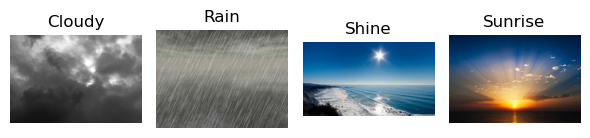

In [94]:
fig = plt.figure(figsize=(6,6)) 
rows = 3
columns = 4


for i, image_filename in enumerate(os.listdir(train_path)):

    first_img_path = os.listdir(os.path.join(train_path, image_filename))[0]
    first_image = imread(os.path.join(train_path, image_filename, first_img_path))
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(first_image)
    plt.title('{}'.format(image_filename, fontsize=10))

plt.tight_layout()
plt.show()

In [95]:
all_data_sum=0
images_count_dict = {}
for image_filename in os.listdir(train_path):

    folder_path = os.path.join(train_path, image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    all_data_sum+= images_count
    print('{} folder has {} images'.format(image_filename ,  images_count))

print("\nTotal Number of Images: {} image".format(all_data_sum))


Cloudy folder has 263 images
Rain folder has 188 images
Shine folder has 221 images
Sunrise folder has 312 images

Total Number of Images: 984 image


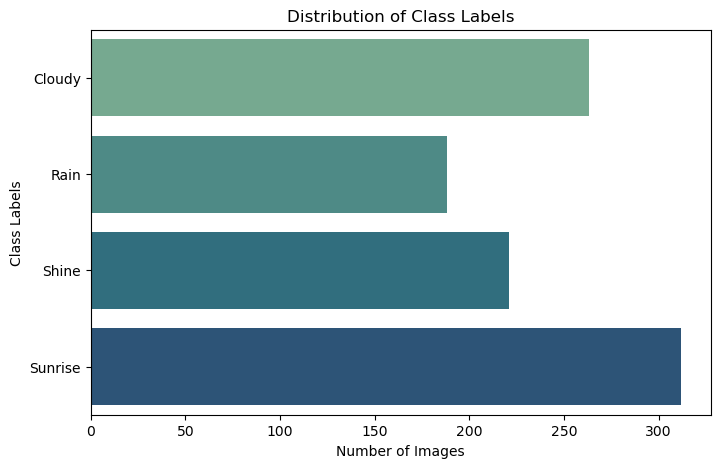

In [96]:
data = list(images_count_dict.items())

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(y=[x[0] for x in data], x=[x[1] for x in data], palette='crest',orient='horizontal')
plt.ylabel('Class Labels')
plt.xlabel('Number of Images')
plt.title('Distribution of Class Labels');

### As we can observe from the plot, the data is much more balanced now compared to the original dataset. Also, we have doubled the size of the dataset

**Hyperparamters**

In [97]:
# ImageNet architectures excpect the image shapes to be 224 x 224
image_shape = (224,224,3)
batch_size = 16
epochs = 25
no_classes = 4

## Preparing the Data for the model

- We've split the data into `80% for training` and `20% for testing`. 
- Augmentation techniques have been applied to certain classes within the training dataset.
- Since we've already augmented the dataset and saved the augmented images to disk, therefore we are now using an ImageDataGenerator to load the augmented images during training only.

In [98]:
train_image_gen = ImageDataGenerator(rescale=1/255,            # rescale the image by normalzing it
                                     validation_split=0.1447)      # split the data into 80% validation , 20% testing

test_image_gen = ImageDataGenerator(rescale=1/255)             # rescale the image by normalzing it
                                 

In [99]:
# Defining training dataset
train_image_ds = train_image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset = 'training')

Found 843 images belonging to 4 classes.


In [100]:
# Defining validation dataset
val_image_ds = train_image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset = 'validation')

Found 141 images belonging to 4 classes.


In [101]:
# Defining testing dataset
test_image_ds = test_image_gen.flow_from_directory(test_path,
                                                  target_size=image_shape[:2],
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Do not shuffle to keep the order consistent

Found 141 images belonging to 4 classes.


In [102]:
images, one_hot_labels = next(train_image_ds)
# get the 'one' which is corresponding to target label
labels = np.argmax(one_hot_labels, axis=1)

In [103]:
images[0].max()

1.0

In [104]:
images[0].min()

0.10196079

##  Displaying sample of Augmented Data

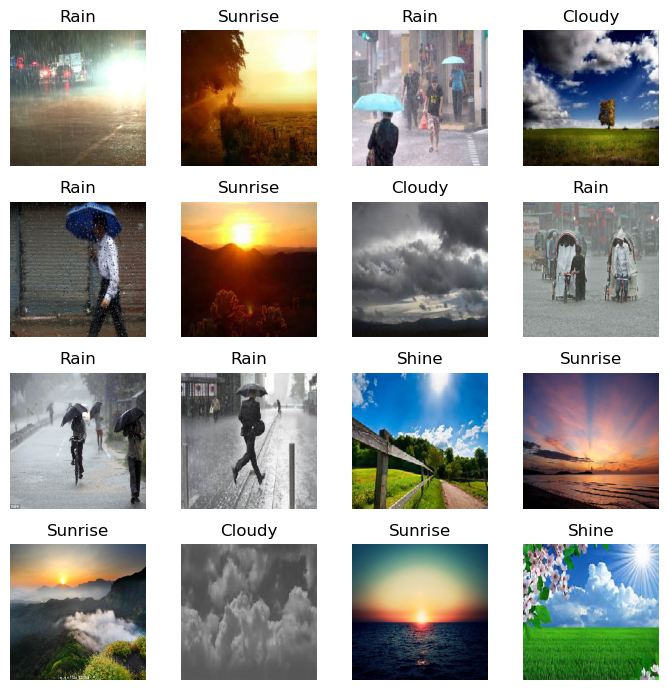

In [105]:
# invert the dictionary using dict comprehension
label_names = {value: key for key, value in train_image_ds.class_indices.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(7,7))
ax = ax.flatten()

for i in range(16):
    ax[i].imshow(images[i])
    ax[i].set_title('{}'.format(label_names[labels[i]]))
    ax[i].axis('off')
plt.tight_layout()
plt.show()

______________________________________________

# Model Training

## Transfer Learning
### Why use pre-trained model for Image Classification tasks?

Transfer learning is useful for image classification tasks due to several reasons:

- **Feature Extraction**: as our dataset is not considered a large one, a pre-trained convolutional neural networks (CNNs), such as those trained on ImageNet, have learned to extract rich and complex features from images.By leveraging these pre-trained models as feature extractors, transfer learning allows us to benefit from the representations learned by the CNNs on a diverse dataset. This can significantly improve the performance of image classification models, especially when working with limited labeled data.

- **Domain Adaptation**: Image classification tasks often involve diverse datasets with variations in image quality, lighting conditions, viewpoints, and object appearances. Pre-trained models have learned to capture generic features that are transferable across different domains.By fine-tuning a pre-trained model on a target dataset, transfer learning helps adapt the learned representations to the specific characteristics of the target dataset, improving classification accuracy.

- **Faster Convergence Time**: Training deep CNNs from scratch on large-scale image datasets can be computationally intensive and time-consuming. Transfer learning allows us to initialize the model with pre-trained weights, which serve as a good starting point for optimization. This often leads to faster convergence during training and shorter training times compared to training from scratch.

- **Mitigate the risk of Overfitting**: Pre-trained models act as effective regularizers by providing strong priors on the model's parameters. Fine-tuning a pre-trained model on a target dataset helps prevent overfitting, especially when the target dataset is small. Transfer learning encourages the model to learn task-specific features while retaining the generalization capabilities acquired from the source dataset.

## 1. DenseNet Architecture

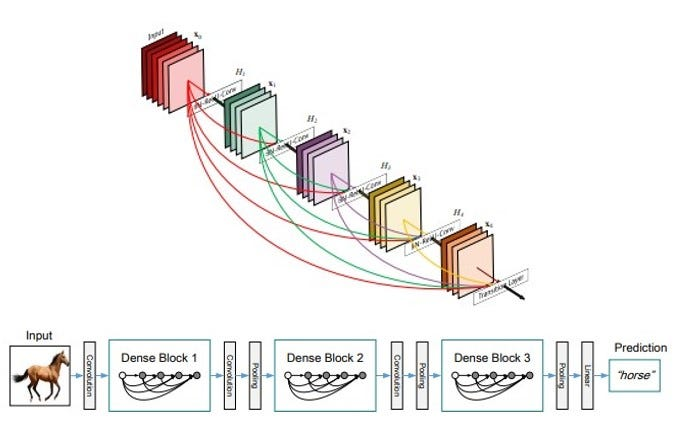

DenseNet-121 is a variant of the DenseNet architecture, designed to balance model depth and computational efficiency. DenseNet-121 is characterized by its **121-layer deep network with densely connected convolutional layers**.

### Key Features of DenseNet-121:

- **Dense Connectivity**: DenseNet-121 employs dense connectivity between layers, where each layer is connected to every other layer in a feed-forward fashion. This dense connectivity promotes feature reuse and facilitates information flow throughout the network, leading to more effective feature extraction.

- **Bottleneck Layers**: Similar to other DenseNet variants, DenseNet-121 utilizes bottleneck layers to reduce computational complexity and memory footprint. Bottleneck layers consist of 1x1 convolutional layers followed by 3x3 convolutional layers, aiding in dimensionality reduction and feature extraction.

- **Growth Rate**: DenseNet-121 maintains a growth rate parameter, which controls the number of feature maps produced by each layer in the network. This parameter influences the model's capacity to learn and adapt to complex patterns in the data.


- **Steps**
1. Load the ImageNet weights.

2. Include the top layers of a pre-trained model but exclude the final softmax layer, by setting include_top=True and then remove the final layer manually. so it allows us to use the pre-trained convolutional base and intermediate fully connected layers while customizing the final output layer according to our specific task.

3. Removing the final layer of the ImageNet task.

4. Iterate through all the layers in dense_model using a for loop. For each layer, we set the trainable attribute to False, effectively freezing the layer's weights during training.

5. Adding our custom layer (11 classes)


In [107]:
# Load pre-trained DenseNet model 
dense_model = DenseNet121(weights='imagenet',
                          include_top=True,
                          input_shape = image_shape)

# Remove the final layer (softmax)
dense_model = Model(inputs=dense_model.input, outputs=dense_model.layers[-2].output)

# Freeze Layers
for layer in dense_model.layers:
    layer.trainable = False
    
# Adding a dropout layer
dropout_layer = Dropout(0.45)(dense_model.output)
layer = Dense(64, kernel_regularizer=L1(0.016))

# Adding batch normalization
batch_norm_layer = BatchNormalization()(dropout_layer)

activation = Activation('relu')(batch_norm_layer)

# Adding our custom layer for our specific task
output = Dense(no_classes, activation='softmax')(activation)

# Define our model with the modified output layer
model = Model(inputs=dense_model.input, outputs=output)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [108]:
early_stop = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True )

In [111]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_image_ds,
                    epochs=25,
                    validation_data=val_image_ds,
                    verbose = 1,
                    shuffle = True)

Epoch 1/25
53/53 [==============================] - 57s 984ms/step - loss: 0.1994 - accuracy: 0.9288 - val_loss: 0.3077 - val_accuracy: 0.8794
Epoch 2/25
53/53 [==============================] - 59s 1s/step - loss: 0.1626 - accuracy: 0.9466 - val_loss: 0.3396 - val_accuracy: 0.8582
Epoch 3/25
53/53 [==============================] - 64s 1s/step - loss: 0.1622 - accuracy: 0.9502 - val_loss: 0.3246 - val_accuracy: 0.8652
Epoch 4/25
53/53 [==============================] - 51s 957ms/step - loss: 0.1462 - accuracy: 0.9573 - val_loss: 0.3260 - val_accuracy: 0.8723
Epoch 5/25
53/53 [==============================] - 50s 943ms/step - loss: 0.1514 - accuracy: 0.9514 - val_loss: 0.3184 - val_accuracy: 0.8794
Epoch 6/25
53/53 [==============================] - 50s 951ms/step - loss: 0.1415 - accuracy: 0.9502 - val_loss: 0.3111 - val_accuracy: 0.8652
Epoch 7/25
53/53 [==============================] - 50s 950ms/step - loss: 0.1224 - accuracy: 0.9620 - val_loss: 0.3197 - val_accuracy: 0.8652
Epoch

# Model Evaluation

In [112]:
# Loss and Accuracy on validation data
model.evaluate(val_image_ds,verbose=0)

[0.34174835681915283, 0.8794326186180115]

In [113]:
# Loss and Accuracy on test data (new unseen data)
model.evaluate(test_image_ds,verbose=0)

[0.08360487967729568, 0.9645389914512634]

In [114]:
# Generate predictions using the trained model on the test dataset.
predictions_prob = model.predict(test_image_ds,verbose=0)

In [115]:
# Select the class with the highest probability as the predicted class
predictions = np.argmax(predictions_prob, axis=1)

In [116]:
print(classification_report(test_image_ds.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        37
           1       1.00      1.00      1.00        27
           2       0.89      1.00      0.94        32
           3       0.98      0.96      0.97        45

    accuracy                           0.96       141
   macro avg       0.97      0.97      0.97       141
weighted avg       0.97      0.96      0.96       141



- According to classification report, the model's average precision for all classes is approximately 85%, meaning that 85% of the predictions it classified for each class are accurate.
- The model can accurately identify about 85% of all cases that belong to each class, according to the average recall of 85% across all classes.
- All classes combined have an average F1-score of 85%, which denotes good overall performance.
- For the accuracy of 0.85 , the model is able to accurately predict the class label for almost 85% of the data.
- Macro average treats all classes equally,while weighted average accounts for class imbalance by weighting each class's score by its count(support). In this report, both macro and weighted averages have similar values, indicating balanced performance across classes.

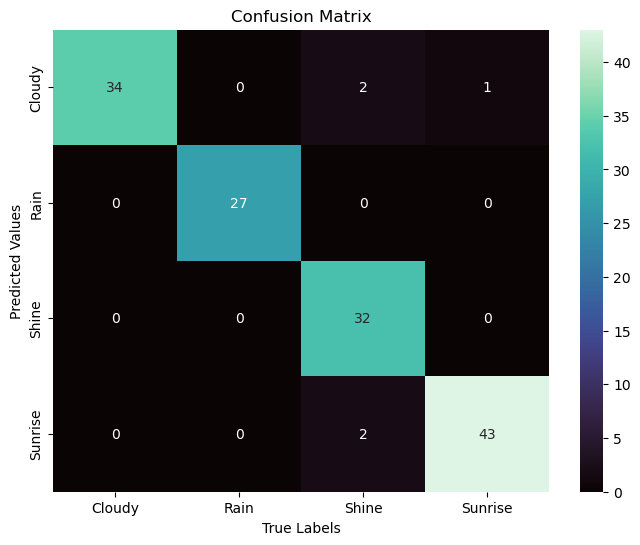

In [123]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(test_image_ds.classes,predictions)
ax = sns.heatmap(cm,annot=True,fmt='d',cmap='mako')
ax.set_xticklabels(test_image_ds.class_indices.keys())
ax.set_yticklabels(test_image_ds.class_indices.keys())

plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix');

# Result Visualization

In [125]:
metrics = pd.DataFrame(history.history)

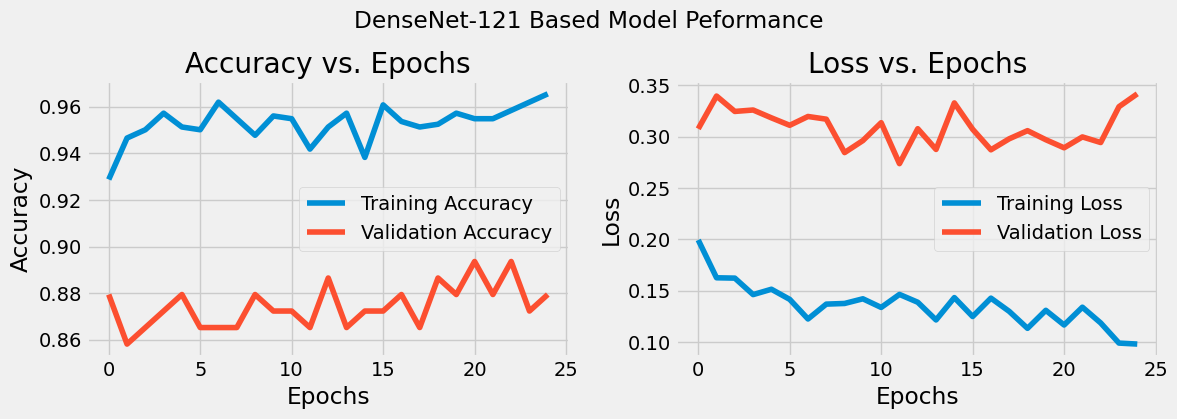

In [127]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('DenseNet-121 Based Model Peformance', y = 1.05)
plt.show()

In [128]:
#Save the model
model.save('densenet-121.h5')

C:\Users\zizaM\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
